<a href="https://colab.research.google.com/github/Amine-Guesmi/mini_projet_RN/blob/main/miniProjet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Load libraries
import os
import numpy as np
import torch
import glob
from PIL import Image
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib


In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [ ]:
from google.colab import drive
  
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/PyTorch/datasets/mammo/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transformer=transforms.Compose([
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])


In [ ]:
transformer

Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [ ]:
#Dataloader

#Path for training and testing directory
train_path='train'
test_path='test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [ ]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

['BEN', 'CAN', 'NOR']

In [ ]:
test_np = np.array(test_loader.dataset)
test_np

In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


helper_functions.py already exists, skipping download


In [ ]:
# Create a convolutional neural network 
class ModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=10240, 
                      out_features=output_shape)
        )
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.dropout(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = ModelV2(input_shape=3, 
    hidden_units=10, 
    output_shape=len(classes)).to(device)
model_2


ModelV2(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
# Setup loss and optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
optimizer=Adam(model_2.parameters(),lr=0.001,weight_decay=0.0001)




In [ ]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
test_count=len(glob.glob(test_path+'/**/*.png'))


In [ ]:
print(train_count,test_count)



7870 3308


In [ ]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_loader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)
[0.8219,0.8367,0.8469,0.8532,0.8527,0.8536,0.8590,0.8643,0.8612,0.8647,0.8690,0.8751,0.8840,0.8853,0.8959,0.9032,0.9144,0.9170,0.9293,0.9309]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.60362 | Train accuracy: 82.19%
Test loss: 0.55566 | Test accuracy: 83.03%

Epoch: 1
---------
Train loss: 0.47900 | Train accuracy: 83.67%
Test loss: 0.52662 | Test accuracy: 83.69%

Epoch: 2
---------
Train loss: 0.44526 | Train accuracy: 84.69%
Test loss: 0.50755 | Test accuracy: 84.18%

Epoch: 3
---------
Train loss: 0.42875 | Train accuracy: 85.32%
Test loss: 0.53375 | Test accuracy: 84.40%

Epoch: 4
---------
Train loss: 0.42260 | Train accuracy: 85.27%
Test loss: 0.51356 | Test accuracy: 84.03%

Epoch: 5
---------
Train loss: 0.41454 | Train accuracy: 85.36%
Test loss: 0.51820 | Test accuracy: 83.97%

Epoch: 6
---------
Train loss: 0.40215 | Train accuracy: 85.90%
Test loss: 0.50390 | Test accuracy: 84.06%

Epoch: 7
---------
Train loss: 0.39398 | Train accuracy: 86.43%
Test loss: 0.52516 | Test accuracy: 84.29%

Epoch: 8
---------
Train loss: 0.39771 | Train accuracy: 86.12%
Test loss: 0.52491 | Test accuracy: 82.96%

Epoch: 9
---------
Train los

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [ ]:
model_2_results = eval_model(
    model=loaded,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results


{'model_name': 'ModelV2',
 'model_loss': 1.0809727907180786,
 'model_acc': 81.2099358974359}

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [ ]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_np), k=20):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[5]} ({classes[test_labels[5]]})")


Test sample image shape: torch.Size([3, 128, 128])
Test sample label: 2 (NOR)


In [ ]:
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs


tensor([[0.3199, 0.3391, 0.3410],
        [0.3193, 0.3395, 0.3412],
        [0.3198, 0.3395, 0.3406],
        [0.3202, 0.3385, 0.3413],
        [0.3198, 0.3381, 0.3421],
        [0.3190, 0.3379, 0.3431],
        [0.3198, 0.3390, 0.3411],
        [0.3192, 0.3397, 0.3411],
        [0.3205, 0.3384, 0.3411],
        [0.3195, 0.3392, 0.3413],
        [0.3199, 0.3387, 0.3414],
        [0.3205, 0.3385, 0.3410],
        [0.3197, 0.3365, 0.3438],
        [0.3200, 0.3387, 0.3414],
        [0.3212, 0.3383, 0.3404],
        [0.3211, 0.3382, 0.3407],
        [0.3200, 0.3388, 0.3412],
        [0.3189, 0.3399, 0.3413],
        [0.3197, 0.3396, 0.3407],
        [0.3202, 0.3384, 0.3413]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
test_labels, pred_classes

([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2],
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "model_2_20ep_adam_dropout_pre.pth"
MODEL_PKL = "model_2_20ep_pre"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
PKL = MODEL_PATH / MODEL_PKL


# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/model_2_20ep_adam_dropout_pre.pth


In [ ]:
torch.save(obj=model_2,f=PKL)


In [ ]:
NAME = "model_2_20ep_adam_dropout.pth"
MODEL_SAVE_PATH = MODEL_PATH / NAME

loaded_model = ModelV2(input_shape=3, 
    hidden_units=10, 
    output_shape=len(classes)).to(device)

# Load state_dict
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))



<All keys matched successfully>

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])


In [ ]:
from PIL import Image
img = Image.open("/content/drive/MyDrive/PyTorch/datasets/mammo/pred/BEN/10100.png").convert('RGB')

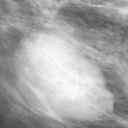

In [ ]:
img

In [ ]:
input = transform(img)

In [ ]:
input = input.unsqueeze(0)

In [ ]:
loaded_model.eval()

ModelV2(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
output = loaded_model(input)

In [ ]:
pred_prob = torch.softmax(output.squeeze(), dim=0)

In [ ]:
pred = pred_prob.argmax()

In [ ]:
pred

tensor(1)

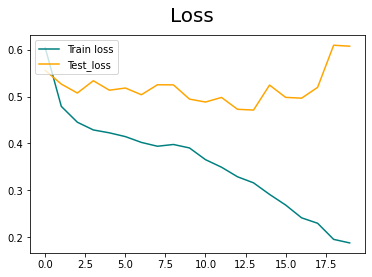

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_loss, color='teal', label='Train loss')
plt.plot(test_loss, color='orange', label='Test_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


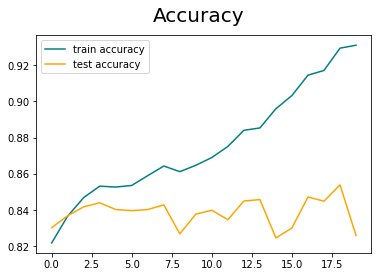

In [ ]:
fig = plt.figure()
plt.plot(train_accuracy, color='teal', label='train accuracy')
plt.plot(test_accuracy, color='orange', label='test accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

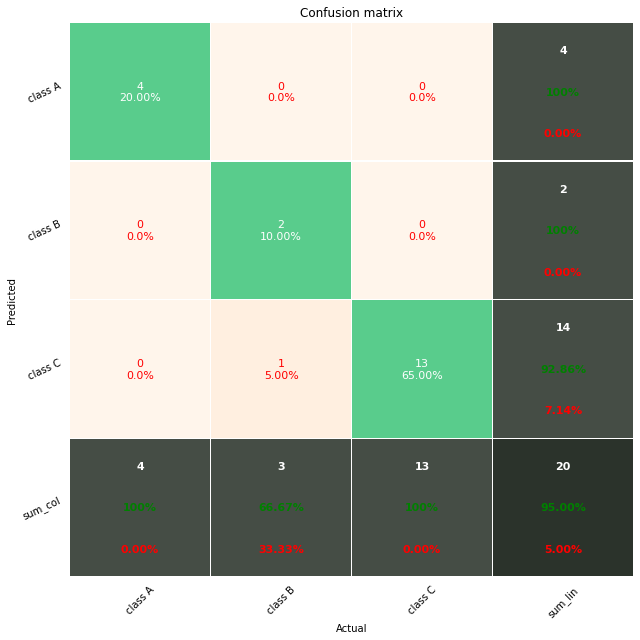

In [ ]:
from pretty_confusion_matrix import pp_matrix_from_data
t = np.array(testData)
p = np.array(pred)
pp_matrix_from_data(t, p)